# How to use KARABO

In [17]:
from karabo.imaging import imager
from karabo.sourcedetection.result import SourceDetectionResult
from karabo.simulation.telescope import Telescope
from karabo.simulation.observation import Observation
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.sky_model import SkyModel

# Render plots inline
%matplotlib inline

## Simulation

The sky and telescope simulation is currently provided completely by OSKAR.

We use the built-in GLEAM Sky Catalog for our sky model.

/home/kenfus/miniconda3/envs/karabo/lib/python3.9/site-packages/karabo/simulation/sky_model.py:424: RuntimeWarning: invalid value encountered in log10
  log_flux = np.log10(flux)


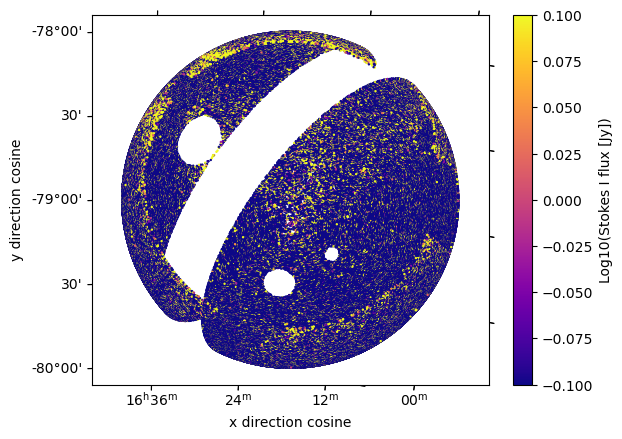

In [13]:
# Get GLEAM Survey Sky
phase_center = [250, -80]
gleam_sky = SkyModel.get_GLEAM_Sky()
gleam_sky.plot_sky(phase_center)

Then we filter the sky model based on radius.

In [14]:
sky = gleam_sky.filter_by_radius(0, .55, phase_center[0], phase_center[1])
sky.setup_default_wcs(phase_center=phase_center)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIR'  'DEC--AIR'  
CRVAL : 250.0  -80.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -1.0  1.0  
NAXIS : 0  0

Let's have a closer look with the 2d image project explore_sky() provides.

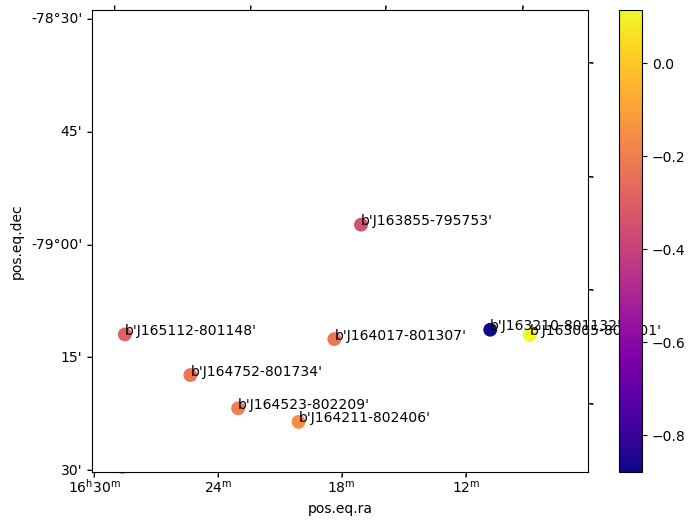

In [15]:
sky.explore_sky(phase_center=phase_center, figsize=(8, 6), s=80,
                xlim=(-.55, .55), ylim=(-.55, .55), with_labels=True)

### Telescope Module

Various observation parameters and meta information `params` must be passed to the telescope module `oskar.Interferometer` of OSKAR as `oskar.SettingsTree`.

In [ ]:
askap_tel = Telescope.get_ASKAP_Telescope()
askap_tel.plot_telescope()

### Observation Simulation

Now the sky module must be passed to the interferometer and the simulation of the observation must be started to generate the measurement set.

In [19]:
observation_settings = Observation(100e6,
                                        phase_centre_ra_deg=phase_center[0],
                                        phase_centre_dec_deg=phase_center[1],
                                        number_of_channels=64,
                                        number_of_time_steps=24)

interferometer_sim = InterferometerSimulation(channel_bandwidth_hz=1e6)
visibility_askap = interferometer_sim.run_simulation(askap_tel, sky, observation_settings)

NameError: name 'askap_tel' is not defined

### Dirty Images

We can create dirty images of visibilites and display them as shown below

<SkyCoord (ICRS): (ra, dec) in deg
    (250., -80.)>
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 250.0  -80.0  1.0  100000000.0  
CRPIX : 1025.0  1025.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.0022222222222222  0.0022222222222222  1.0  1.0  
NAXIS : 2048  2048  1  64


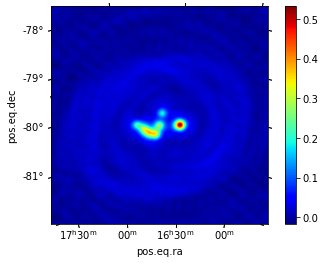

In [7]:
imager_askap = imager.Imager(visibility_askap, imaging_npixel=2048,
                             imaging_cellsize=3.878509448876288e-05)
dirty = imager_askap.get_dirty_image()
dirty.plot()

### Imaging

In [8]:
imager_askap.ingest_chan_per_blockvis = 1
imager_askap.ingest_vis_nchan = 16

deconvolved, restored, residual = imager_askap.imaging_rascil(
    clean_nmajor=0,
    clean_algorithm='mmclean',
    clean_scales=[0, 6, 10, 30, 60],
    clean_fractional_threshold=.3,
    clean_threshold=.12e-3,
    clean_nmoment=5,
    clean_psf_support=640,
    clean_restored_output='integrated')

2022-06-03 14:13:31,622 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/cvoegele/development/SKA/karabo/examples/dask-worker-space/worker-8b8b9qqz', purging
2022-06-03 14:13:31,623 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/cvoegele/development/SKA/karabo/examples/dask-worker-space/worker-sh_kvlis', purging
2022-06-03 14:13:31,623 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/cvoegele/development/SKA/karabo/examples/dask-worker-space/worker-tz9fj9gh', purging


LocalCluster(797f595b, 'tcp://127.0.0.1:51270', workers=3, threads=9, memory=16.00 GiB)


2022-06-03 14:15:15,144 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.42 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:15:17,537 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.77 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:15:19,646 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.80 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:15:20,538 - distributed.worke

2022-06-03 14:15:39,464 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.75 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:15:39,537 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.84 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:15:41,237 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.82 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:15:41,340 - distributed.worke

2022-06-03 14:16:01,737 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.74 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:16:01,840 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.81 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:16:01,937 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.83 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:16:02,037 - distributed.worke

2022-06-03 14:16:20,341 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.83 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:16:22,037 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.77 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:16:22,206 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.97 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:16:22,238 - distributed.worke

2022-06-03 14:16:32,342 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.84 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:16:32,438 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.82 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:16:32,538 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.75 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:16:33,237 - distributed.worke

2022-06-03 14:16:49,438 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.74 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:16:52,442 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.85 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:16:52,540 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.77 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:16:54,137 - distributed.worke

2022-06-03 14:17:05,037 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.75 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:17:05,738 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 4.00 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:17:06,737 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 4.06 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:17:06,839 - distributed.worke

2022-06-03 14:17:19,438 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.98 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:17:19,538 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.83 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:17:19,637 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.85 GiB -- Worker memory limit: 5.33 GiB
2022-06-03 14:17:21,137 - distributed.worke

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 250.0  -80.0  1.0  100000000.0  
CRPIX : 1025.0  1025.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.0022222222222222  0.0022222222222222  1.0  1.0  
NAXIS : 2048  2048  1  16


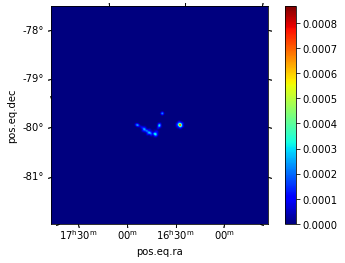

In [9]:
# Any of the resulting output images of the CLEAN algorithm can be displayed and saved.
deconvolved.plot()
deconvolved.save_as_fits("./deconvolved_ASKAP_observation.fits")
restored.save_as_fits("./restored.fits")

## Analysis via Source Detection

Source Detection on restored image.

In [20]:
detection_result = SourceDetectionResult.detect_sources_in_image(restored)

NameError: name 'restored' is not defined

In [ ]:
detection_result.detection.show_fit()

NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


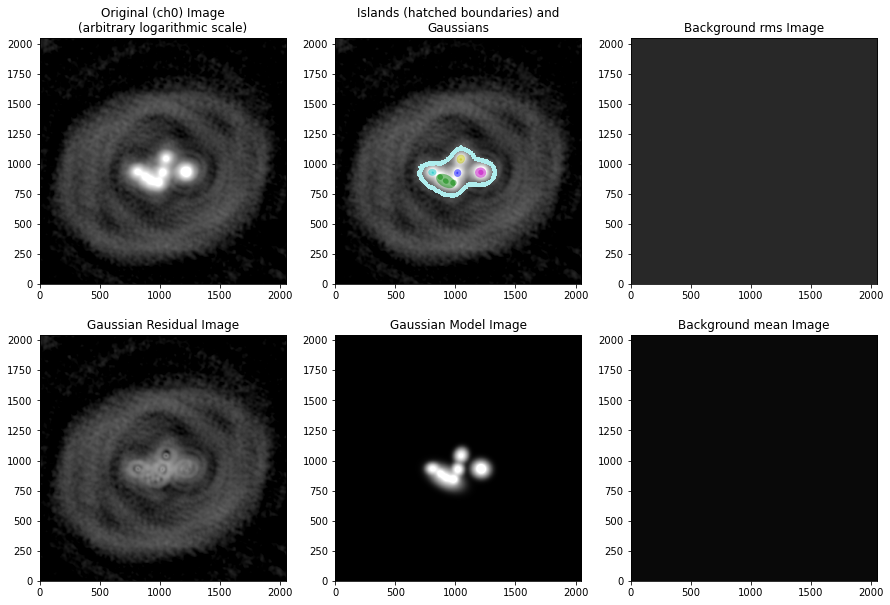

True

In [15]:
detection_result.detection.show_fit()

In [21]:
# the phase centered wcs needs to be set on the sky for the sky to detection mapping to work.
sky.setup_default_wcs(phase_center=observation_settings.get_phase_centre())
detection_evaluation = source_detection.map_sky_to_detection(sky, 3.878509448876288e-05, 2048, detection_result, 20)

AttributeError: type object 'SourceDetectionResult' has no attribute '__map_sky_to_detection'

[[1210.06183524 1018.87825165  808.54643891  983.80790081 1212.41286288
   919.69019978 1045.40593177  920.28541043  873.96228616 1045.16765915
  1016.24066627  812.05505397]
 [ 928.75137154  925.07241064  931.07041867  843.7716342   930.41913174
   859.07125655 1040.97648684  858.12933171  891.59416821 1037.88167324
   926.12419057  928.06379355]]
[[ 983.7541719   923.47622896  875.76150634 1214.68252179 1019.4823065
  1175.05313524  810.42477501 1046.05954221]
 [ 843.99399139  857.57544953  890.71521423  930.8138393   926.59679683
   935.95007904  931.27137963 1040.78864429]]


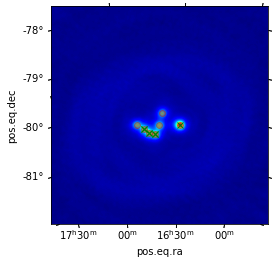

In [12]:
print(detection_evaluation.pixel_coordinates_detection)

print(detection_evaluation.pixel_coordinates_sky)
detection_evaluation.plot()